<a href="https://colab.research.google.com/github/yustinaivanova/netology_statistics/blob/master/lecture_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лекция 4. Кейс-стади. Статистические показатели.

In [0]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns

%matplotlib inline


Загрузим датасет 'Faulty-steel-plates' с kaggle:

In [2]:
import io
import requests
url="http://yustiks.ru/faults.csv"
dataset_temp=pd.read_csv(url) 
dataset_temp.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


В данном датасете 34 атрибута. Первые 27 атрибутов описывают некоторые несиправности стальной платы, которые были замечены в изображениях.

*    X_Minimum
*   X_Maximum
*    Y_Minimum
*    Y_Maximum
*    Pixels_Areas
*    X_Perimeter
*    Y_Perimeter
*    Sum_of_Luminosity
*    Minimum_of_Luminosity
*    Maximum_of_Luminosity
*    Length_of_Conveyer
*    TypeOfSteel_A300
*    TypeOfSteel_A400
*    Steel_Plate_Thickness
*    Edges_Index
*    Empty_Index
*    Square_Index
*    Outside_X_Index
*    Edges_X_Index
*    Edges_Y_Index
*    Outside_Global_Index
*    LogOfAreas
*    Log_X_Index
*    Log_Y_Index
*    Orientation_Index
*    Luminosity_Index
*    SigmoidOfAreas

Последние 7 колонок - это класс, к которому относится то или иное повреждение (one-hot-encoding). Например, если какой-либо элемент классифицируется как "Stains" (пятна), то в колонке 'Stains' 
будет стоять единица. Последние 7 атрибутов представляют собой класс для каждого элемента.

*    Pastry
*    Z_Scratch
*    K_Scatch
*    Stains
*    Dirtiness
*    Bumps
*    Other_Faults


Первые 27 колонок данной таблицы являются колонками для предсказаний класса.


In [3]:
data = dataset_temp.iloc[:,:27]
data[:4]

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212



Посмотрим частотный график данных колонок (график histograms):

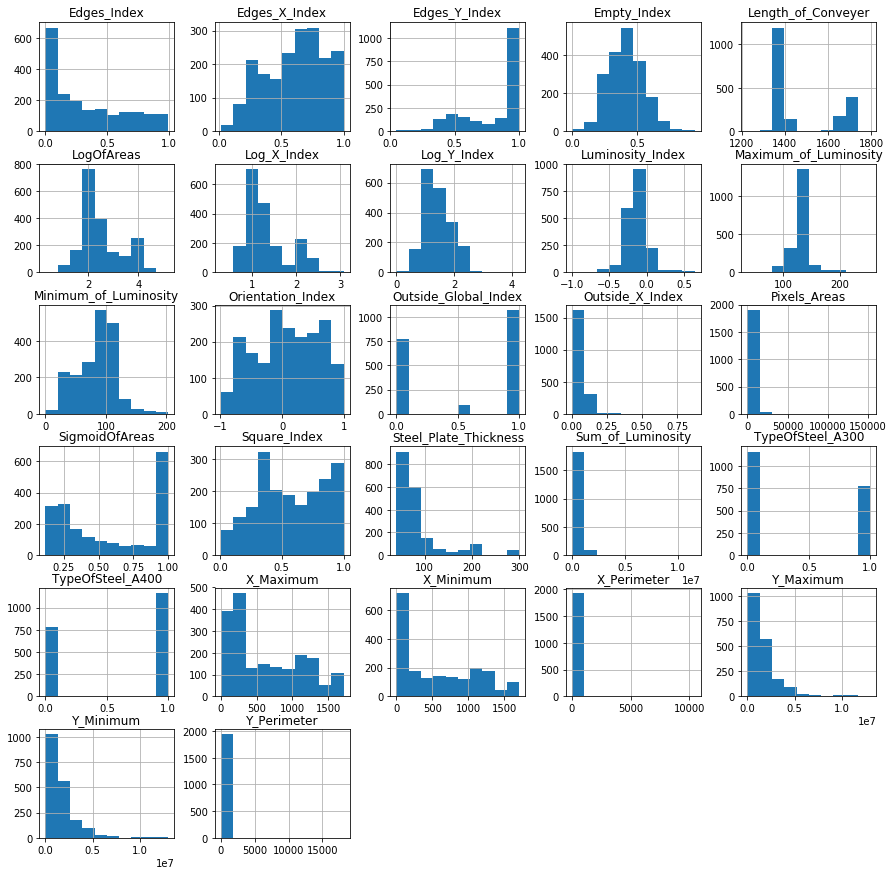

In [4]:

data.hist(figsize=(15,15))
plt.show()


Из данных графиков можно увидеть, что Outside_Global_Index, TypeOfSteel_A300, TypeOfSteel_A400 являются дискретными величинами со значениями [0, 0.5, 1], [0,1], [0,1] соответственно (распределение Бернулли).

Можно также заметить, что такие переменные, как Empty_Index, Log_Y_Index, Luminosity_Index являются нормальным распределением Гаусса.

Выделим колонки в отдельный список

In [0]:
headers = list(data.columns.values)

Нормализуем параметры

In [6]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

np_scaled = min_max_scaler.fit_transform(data)
df_norm = pd.DataFrame(np_scaled)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,0.622575,1.0,-1.0,-0.692308,-0.899920,-0.488293,-0.650096,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,0.622575,1.0,-1.0,-0.692308,0.536777,-0.196313,-0.599476,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,0.396825,1.0,-1.0,-0.538462,0.951367,-0.274076,-0.344560,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,-0.555556,-1.0,1.0,0.923077,0.464429,-0.064943,-0.702934,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,-0.555556,-1.0,1.0,0.115385,-0.860330,-0.049476,-0.883231,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


При нормализации стираются названия колонок, поэтому необходимо восстановить их:

In [7]:
df_norm.columns = headers
df_norm.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,0.622575,1.0,-1.0,-0.692308,-0.899920,-0.488293,-0.650096,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,0.622575,1.0,-1.0,-0.692308,0.536777,-0.196313,-0.599476,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,0.396825,1.0,-1.0,-0.538462,0.951367,-0.274076,-0.344560,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,-0.555556,-1.0,1.0,0.923077,0.464429,-0.064943,-0.702934,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,-0.555556,-1.0,1.0,0.115385,-0.860330,-0.049476,-0.883231,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


Построим матрицу корреляций:

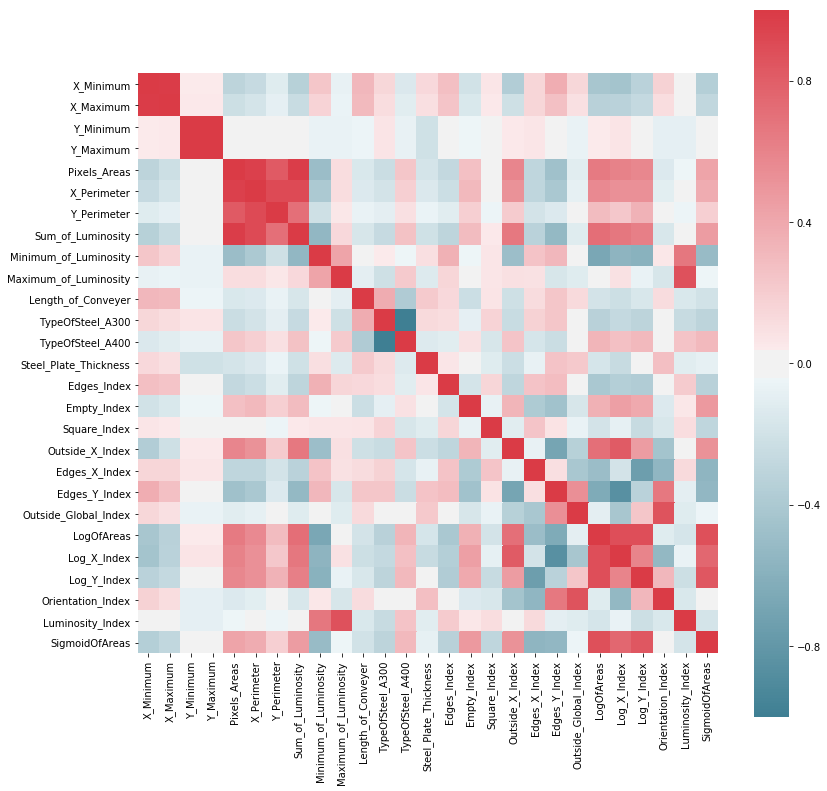

In [19]:
f, ax = plt.subplots(figsize=(13, 13))
corr = df_norm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Некоторые переменные сильно коррелированы (например, Sum_of_Luminosity и Pixels_areas)

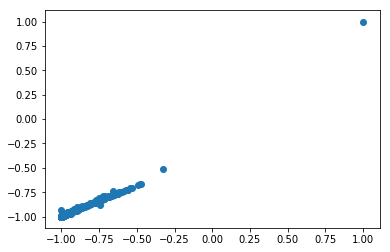

In [20]:
plt.scatter(df_norm['Sum_of_Luminosity'], df_norm['Pixels_Areas'])
plt.show()

Корреляция Пирсона

In [21]:
from scipy.stats import pearsonr
pearsonr(df_norm['Sum_of_Luminosity'], df_norm['Pixels_Areas'])

(0.9789516167596556, 0.0)

Удалим из таблицы значения с корреляцией, большей чем 95% (например, есть метод **усеченное среднее** - когда удаляем 10% минимальных корреляций и 10% максимальных корреляций, но в нашем случае мы берем только максимальные корреляции)

In [22]:
# создаем матрицу корреляций
corr_matrix = df_norm.corr().abs()

# Выбираем верхний треугольник матрицы
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Ищем индексы колонок с корреляцией большей чем 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

['X_Maximum', 'Y_Maximum', 'X_Perimeter', 'Sum_of_Luminosity', 'TypeOfSteel_A400']


Удаляем колонки, которые не нужны:

In [23]:
df_norm = df_norm.drop(df_norm[to_drop], axis=1)
df_norm.head()

,X_Minimum,Y_Minimum,Pixels_Areas,Y_Perimeter,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.950733,-0.959296,-0.996528,-0.995262,-0.251232,-0.342593,0.622575,1.0,-0.692308,-0.899920,-0.488293,-0.650096,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.609987,-0.998611,-0.996805,-0.172414,-0.203704,0.622575,1.0,-0.692308,0.536777,-0.196313,-0.599476,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.761620,-0.999096,-0.998017,-0.024631,-0.185185,0.396825,1.0,-0.538462,0.951367,-0.274076,-0.344560,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,-0.944125,-0.997720,-0.995152,-0.024631,-0.175926,-0.555556,-1.0,0.923077,0.464429,-0.064943,-0.702934,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,-0.924294,-0.968464,-0.971462,-0.635468,-0.175926,-0.555556,-1.0,0.115385,-0.860330,-0.049476,-0.883231,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


После удаления остается 22 колонки:

In [24]:
df_norm.shape

(1941, 22)

Посмотреть разбиение по классам. Сколько элементов в каждом классе?

Pastry	Z_Scratch	K_Scatch	Stains	Dirtiness	Bumps	Other_Faults

In [25]:
print('Количество значений 1го класса: ', dataset_temp[dataset_temp['Pastry']==1].shape)
print('Количество значений 2го класса: ', dataset_temp[dataset_temp['Z_Scratch']==1].shape)
print('Количество значений 3го класса: ', dataset_temp[dataset_temp['K_Scatch']==1].shape)
print('Количество значений 4го класса: ', dataset_temp[dataset_temp['Stains']==1].shape)
print('Количество значений 5го класса: ', dataset_temp[dataset_temp['Dirtiness']==1].shape)
print('Количество значений 6го класса: ', dataset_temp[dataset_temp['Bumps']==1].shape)
print('Количество значений 7го класса: ', dataset_temp[dataset_temp['Other_Faults']==1].shape)


Количество значений 1го класса:  (158, 34)
Количество значений 2го класса:  (190, 34)
Количество значений 3го класса:  (391, 34)
Количество значений 4го класса:  (72, 34)
Количество значений 5го класса:  (55, 34)
Количество значений 6го класса:  (402, 34)
Количество значений 7го класса:  (673, 34)


Количество элементов в каждом классе отличается.

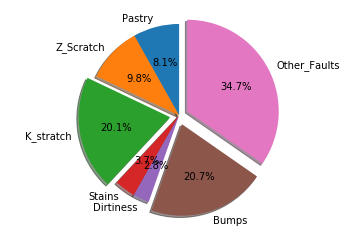

In [31]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Pastry', 'Z_Scratch', 'K_stratch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'
sizes = [158, 190, 391, 72, 55, 402, 673]
explode = (0, 0, 0.1, 0, 0, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Так как есть несбалансированность классов, необходимо уравнять количество элементов в каждом классе засчет генерирования новых (up-sampling) или удаления элементов (down-sampling).

С проблемой классификации с несбалансированными данными хорошо работает метод решения деревьев.

In [0]:
output_y = dataset_temp.iloc[:,27:]
input_x = dataset_temp.iloc[:,:27]

Таргет значение представим ввиде наименований классов.

In [52]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
dtype: int64


Выделим из датасета тренировочные и тестовые данные. 
Тренировочные данные будем использовать для обучения модели.
Тестовые данные будем использовать для подсчета качества модели.

In [0]:
from sklearn.model_selection import train_test_split
X_train_27, X_test_27, y_train_27, y_test_27 = train_test_split(input_x, Y, test_size=0.3)

No handles with labels found to put in legend.


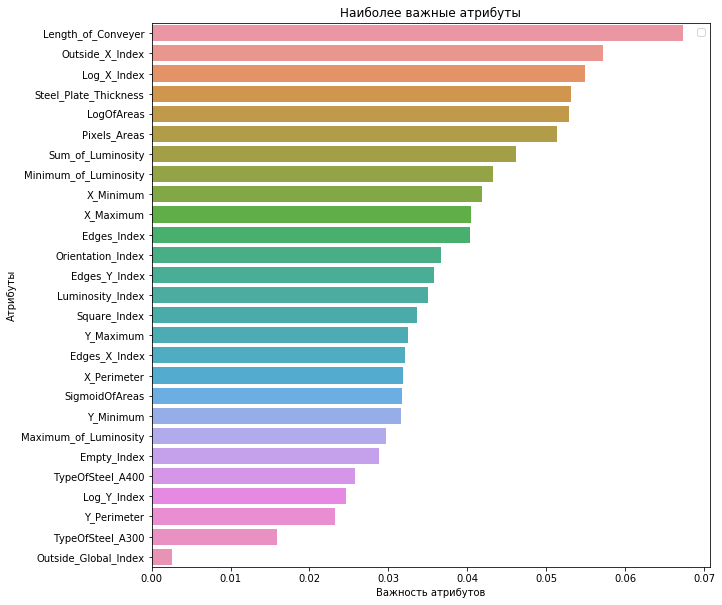

In [47]:
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)

# создаем модель деревья решений
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train_27,y_train_27)

headers = list(X_train_27.columns.values)
feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Мы можем сравнить с теми атрибутами, которые мы удалили, отсекая 10% максимально коррелированных элементов:

In [0]:
['X_Maximum', 'Y_Maximum', 'X_Perimeter', 'Sum_of_Luminosity', 'TypeOfSteel_A400']

Получается, мы не удалили наиболее важные элементы для деревьев решений => хороший признак.

Можно отобразить классы (их всего 7) в 3D пространстве наиболее важных векторов (Length_of_Conveyer, Outside_X_Index, Log_X_Index):

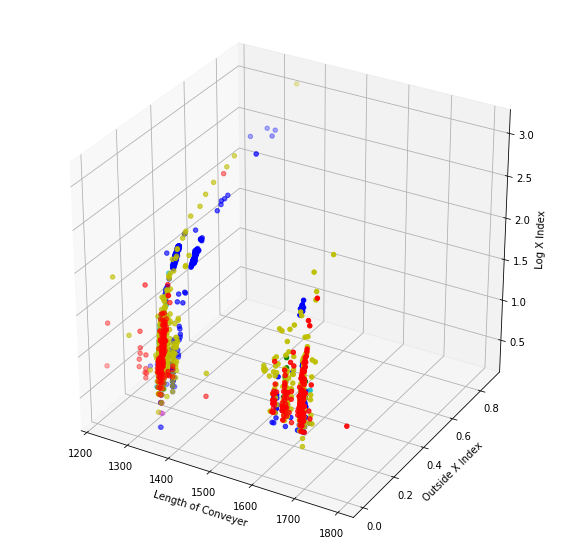

In [106]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', 'y', 'b', 'm', '#17becf']

for i in range(7):
  
  a = df.loc[df['target'] == i, 'Length_of_Conveyer']
  b = df.loc[df['target'] == i, 'Outside_X_Index']
  c = df.loc[df['target'] == i, 'Log_X_Index']

  ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('Length of Conveyer')
ax.set_ylabel('Outside X Index')
ax.set_zlabel('Log X Index')
plt.show()

Можно также посмотреть распределение классов в 3D пространстве по другим атрибутам, например: 'Steel_Plate_Thickness', 'Edges_Index', 'Outside_Global_Index'

In [0]:
df = pd.DataFrame(input_x, columns = ['Steel_Plate_Thickness', 'Edges_Index', 'Outside_Global_Index'])
df['target'] = Y

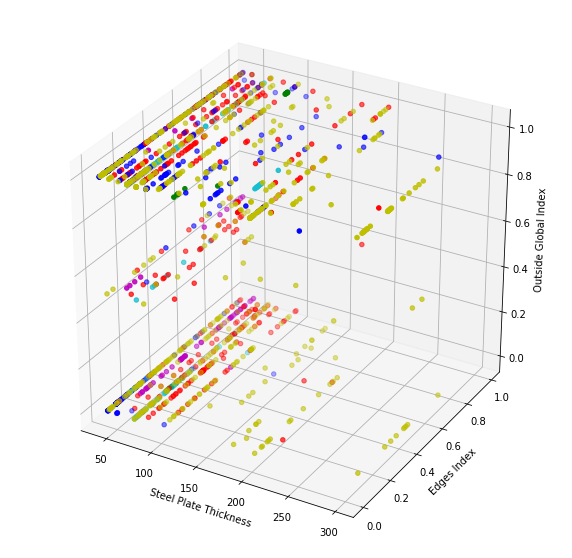

In [116]:

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', 'y', 'b', 'm', '#17becf']

for i in range(7):
  
  a = df.loc[df['target'] == i, 'Steel_Plate_Thickness']
  b = df.loc[df['target'] == i, 'Edges_Index']
  c = df.loc[df['target'] == i, 'Outside_Global_Index']

  ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('Steel Plate Thickness')
ax.set_ylabel('Edges Index')
ax.set_zlabel('Outside Global Index')
plt.show()

Посчитаем качество модели:

In [45]:
model.score(X_test_27, y_test_27)

0.7718696397941681

Модель "рандомных деревьев" дала точность предсказания порядка 77%.

Увеличим количество элементов в таблице для уравновешивания классов.

In [54]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
ros = RandomOverSampler(random_state=0)
X = input_x
ros.fit(X, Y)
X_resampled, y_resampled = ros.fit_sample(X, Y)
print('Количество элементов до операции:', len(X))
print('Количество элементов после операции:', len(X_resampled))

Количество элементов до операции: 1941
Количество элементов после операции: 4711


Мы увеличили количество элементов, и уравняли классы по количеству

In [55]:
unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))

{0: 673, 1: 673, 2: 673, 3: 673, 4: 673, 5: 673, 6: 673}

673
673
673
673
673
673
673


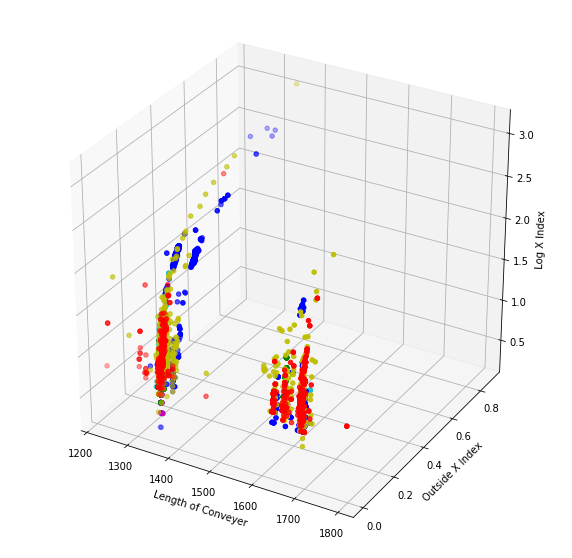

In [108]:
#df = pd.DataFrame(X_resampled, columns = ['Length_of_Conveyer', 'Outside_X_Index', 'Log_X_Index'])
df = pd.DataFrame({'Length_of_Conveyer': X_resampled[:, 10],
                   'Outside_X_Index': X_resampled[:, 17],
                   'Log_X_Index': X_resampled[:, 22]})
df['target'] = y_resampled

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

colors = ['r', 'g', 'b', 'y', 'b', 'm', '#17becf']

for i in range(7):
  
  a = df.loc[df['target'] == i, 'Length_of_Conveyer']
  b = df.loc[df['target'] == i, 'Outside_X_Index']
  c = df.loc[df['target'] == i, 'Log_X_Index']

  ax.scatter(a, b, c, c=colors[i])

ax.set_xlabel('Length of Conveyer')
ax.set_ylabel('Outside X Index')
ax.set_zlabel('Log X Index')
plt.show()

Создадим тренировочный и тестовый датасеты из увеличенного количества данных:

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_resampled,
                                                 y_resampled,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)

Применим алгоритм логистической регрессии:

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
model = LogisticRegression()
model.fit(X_train, y_train)
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test.flatten(),predicted_classes)
print('Точность предсказания модели: ', accuracy)
parameters = model.coef_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Точность предсказания модели:  0.5523338048090524


# Датасет Titanic challenge

Соревнования с kaggle: Titanic challenge. 

Данные разделены на 2 файла: 


*   тренировочные данные ('train.csv')
*   тестовые данные ('test.csv')

Тренировочные данные нужны для построения модели. Для тренировочных данных есть показатель класса для каждого пассажира. Модель будет базироваться на таких значениях как пол пассажира и класс. 

Тестовые данные нужны чтобы посмотреть насколько хорошо модель обучена на тренировочных данных. Для тестовых данных нет показателя класса. Вам необходимо найти класс для каждого пассажира. 

Есть также файл 'gender_submission.csv' как показательный файл того, что нужно загружать в качестве ответа.

Считываем данные с kaggle

In [117]:
url='http://yustiks.ru/titanic/train.csv'
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Итак, есть такие данные, как:


*   PassengerId - id пассажира
*   Survived - выжил или нет (1 - да, 0 - нет)
*   Pclass - класс билеты (1 = 1ый, 2 = 2ой, 3 = 3ий)
*   Namee - имя 
*   Sex - пол 
*   Age - возраст
*   SibSp - количество родных или муж/жена на корабле
*   Parch - количество родителей/детей на корабле
*   Ticket - номер билета
*   Cabin - наименование кабины (NaN - если неизвестно)
*   Embarked - порт отправления (C = Cherbourg, Q = Queenstown, S = Southampton).

Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Начертим график плотности распределения величин. 

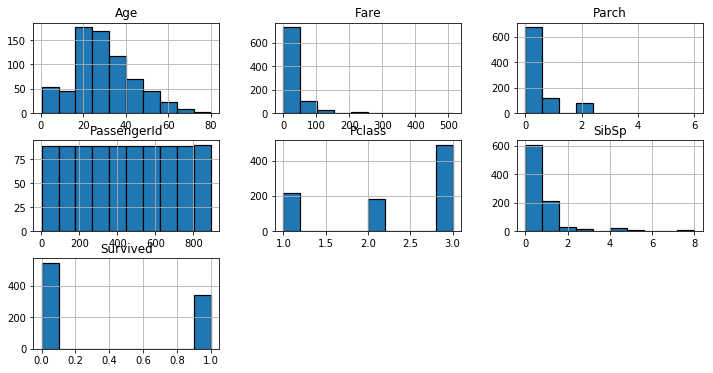

In [118]:
data.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

На графике плотностей распределения четко видны такие распределения, как 


*   Биноминальное распределение ('Survived')
*   Равномерное распределение ('PassengerId')
*   Нормальное ('Age')
*   Логнормальное ('SibSp', 'Fare')


Посмотрим отсутствующие данные:

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


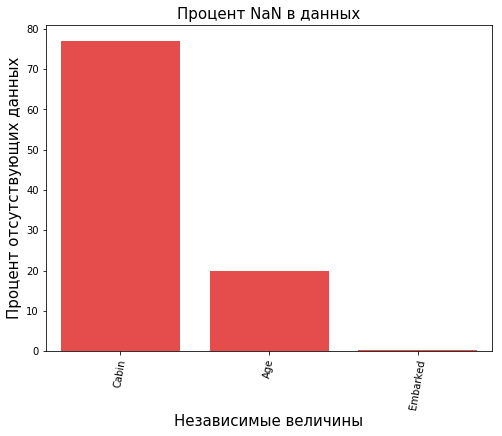

In [119]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='80')
    fig=sns.barplot(ms.index, ms["Percent"],color="red",alpha=0.8)
    plt.xlabel('Независимые величины', fontsize=15)
    plt.ylabel('Процент отсутствующих данных', fontsize=15)
    plt.title('Процент NaN в данных', fontsize=15)
    return ms

missingdata(data)

У нас есть также тестовые данные. Давайте посмотрим, отсутствуют ли в тестовых данных те же самые величины. 

In [120]:
url='http://yustiks.ru/titanic/test.csv'
s=requests.get(url).content
test=pd.read_csv(io.StringIO(s.decode('utf-8')))
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Как можно заметить в тестовых данных нет класса Survived. 

Посмотрим процент отсутствующих данных:

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


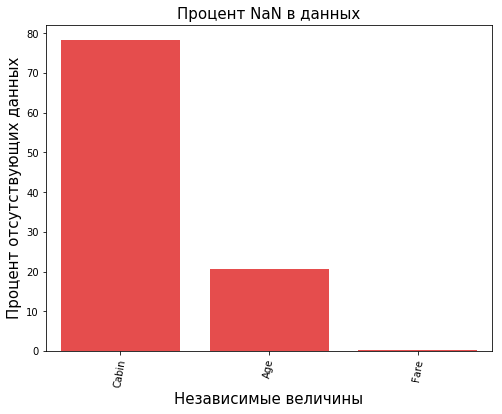

In [121]:
missingdata(test)

График очень похож на тренировочные данные. Необходимо придумать алгоритм, который поможет избавиться от выбросов. 

Во-первых, посмотрим график встречаемости переменной 'Age':

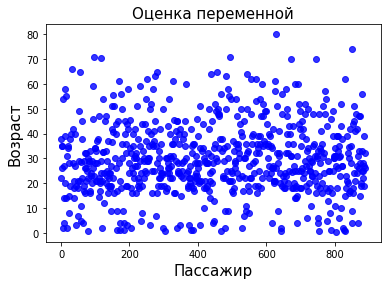

In [122]:
fig=plt.scatter(data.index, data["Age"],color="blue",alpha=0.8)
plt.xlabel('Пассажир', fontsize=15)
plt.ylabel('Возраст', fontsize=15)
plt.title('Оценка переменной', fontsize=15)
plt.show()

Как вариант, можно заполнить неизвестные данные по правилу **медианного фильтра**: вместо Nan можно использовать среднее значение (не всегда работает). 

In [0]:
test['Age'].fillna(test['Age'].median(), inplace = True)
data['Age'].fillna(data['Age'].median(), inplace = True)

То же самое делаем со значением Fare 

In [0]:
test['Fare'].fillna(test['Fare'].median(), inplace = True)

Нам не нужны значения 'Cabin', так как это просто номер кабины - удаляем колонку

In [0]:
drop_column = ['Cabin']
data.drop(drop_column, axis=1, inplace = True)
test.drop(drop_column,axis=1,inplace=True)

Значение Embarked есть отсутствующие значения в таблице тренировочных данных, но нет в тестовых, поэтому в случае с тестовыми данными мы можем например использовать **наиболее встречаемое значение** в качестве заполнения неизвестных (так называемую **моду** - значение признака, имеющее наибольшую частоту в статистическом ряду распределения)

In [0]:
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)

Проверим, имеются ли отсутствующие значения в данных

In [129]:
print('train data:')
print(data.isnull().sum())
print('test data:')
print(test.isnull().sum())

train data:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
test data:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Можно сказать, успешно избавились от выбросов путем заполнения данных с помощью :


*   медианы
*   моды



Объединим теперь данные в один вектор для дальнейших действий

In [0]:
all_data=[data,test]

Наверное, нам не нужны имена, но мы можем использовать такие данные, как Miss, Mister, Mademoiselle (эти данные могут говорить о происхождение человека - англичане), поэтому имеет смысл из имен вычленить только значения Miss, 

In [0]:
import re
# Библиотека re - для применения регулярных выражений
# Let us then extract second word from every row and assign it to a new column. Not only that let us make it categorical (so that we can one-hot encode it) where we observe the most frequent ones.


def title_parser(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Проверяем если значение есть, то возвращаем его, если нет, то возвращаем ''
    if title_search:
        return title_search.group(1)
    return ""
# Создаем новую колонку 'Title' для титула
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(title_parser)
# Если встречаются непонятные титулы, называем их irrelevant
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'irrelevant')
# Некоторые значения также означают Miss - Mlle, Ms, а вот Mme (Madame) означает Mrs
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

Тренировочные данные

In [132]:
all_data[0][:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs


Тестовые данные

In [133]:
all_data[1][:4]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr


Можно увидеть, что вместе с массивом all_data поменялись значения в массиве data и test - добавилась колонка Title

In [134]:
data[:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs


In [135]:
test[:4]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,Mr


На основе имеющихся значений мы можем создать новые: 

In [0]:
# Создаем новое значение FamilySize как комбинацию SibSp и Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    ## создаем Age_bin для значения age 
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

# Создадим класс для fare 
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

Теперь появились новые колонки, которые также могут нести какой-то смысл (не всегда работает)

In [137]:
data[:4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Age_bin,Fare_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,2,Adult,Low_fare
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,2,Adult,high_fare
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1,Adult,median_fare
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,2,Adult,high_fare


Мы можем удалить такие значения как Name и Ticket, так как из Name мы создали категорированные данные (Miss, Mister, Mrs),  а номер билета все равно ни о чем не говорит, поэтому удаляем эти колонки

In [0]:
for dataset in all_data:
    drop_column = ['Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

Проверяем: колонок стало меньше

In [139]:
data[:4]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,Age_bin,Fare_bin
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,2,Adult,Low_fare
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,2,Adult,high_fare
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,1,Adult,median_fare
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,2,Adult,high_fare


Так как у нас получилось много данных категорийных, мы можем заменить эти колонки на вектора **(one-hot encoding)**, таким образом легче для сравнения этих значений

In [140]:
# Пример pd.dummies 
# s = pd.Series(list('abca'))
# pd.get_dummies(s)
#    a  b  c
# 0  1  0  0
# 1  0  1  0
# 2  0  0  1
# 3  1  0  0
data_new = pd.get_dummies(data, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

test_new = pd.get_dummies(test, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

data_new.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'FamilySize', 'Sex_female', 'Sex_male', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_irrelevant', 'Age_type_Children',
       'Age_type_Teenage', 'Age_type_Adult', 'Age_type_Elder', 'Em_type_C',
       'Em_type_Q', 'Em_type_S', 'Fare_type_Low_fare', 'Fare_type_median_fare',
       'Fare_type_Average_fare', 'Fare_type_high_fare'],
      dtype='object')

Получилось довольно много переменных, но насколько эти переменные имеют значение? Некоторые переменные можно исключить, так как они не несут никакой информации (сильно кореллированы с другими переменными). Нарисуем матрицу теплоты для того, чтобы показать корелляцию между переменными. Значение корелляции Пирсона в ячейках матрицы говорит о величине корелляции

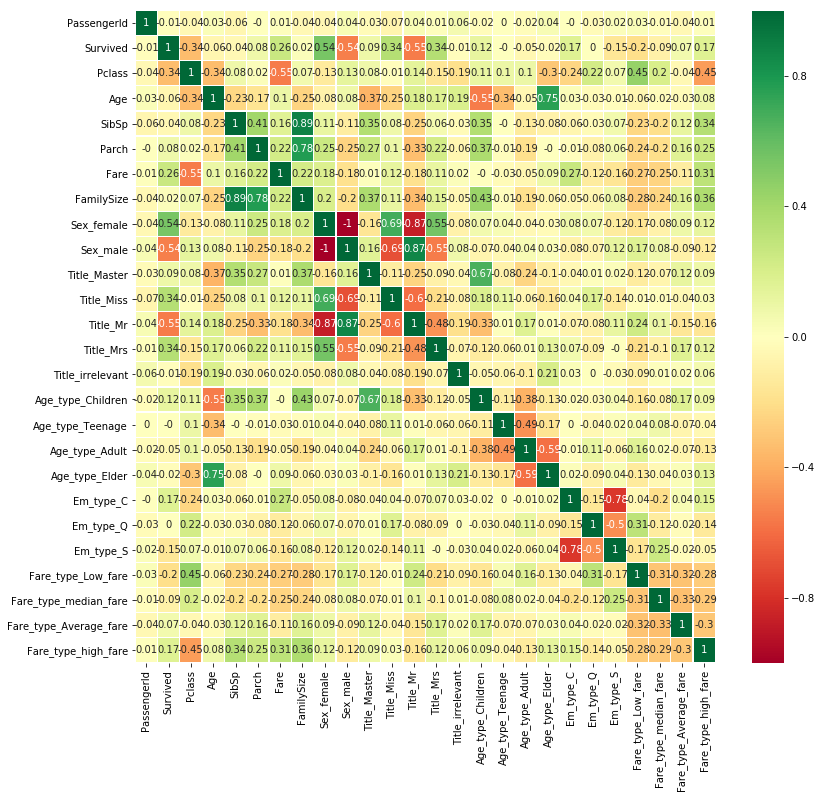

In [142]:
correlation_matrix = data_new.corr(method ='pearson').round(2)
# annot = True чтобы печатать значение внутри ячейки матрицы
sns.heatmap(data=correlation_matrix, yticklabels=True,xticklabels=True, annot=True, cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(13,12)
plt.show()

Можно например объединить такие переменные, которые имеют корелляцию больше чем 70% (красные и зеленые ячейки)

In [143]:
corr_matrix = data_new.corr().abs()

# выбирается верхний треугольник матрицы корелляций (она же симметрична)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# найдем индексы колонок с корелляцией больше чем 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print(to_drop)

['FamilySize', 'Sex_male', 'Title_Mr', 'Age_type_Elder', 'Em_type_S']


In [0]:
data_new = data_new.drop(data_new[to_drop], axis=1)
test_new = test_new.drop(test_new[to_drop], axis=1)

In [145]:
data_new[:2]

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Title_Master,Title_Miss,Title_Mrs,Title_irrelevant,Age_type_Children,Age_type_Teenage,Age_type_Adult,Em_type_C,Em_type_Q,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,1,0,3,22.0,1,0,7.2500,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,2,1,1,38.0,1,0,71.2833,1,0,0,1,0,0,0,1,1,0,0,0,0,1


Нормирование числовых данных

In [0]:
from sklearn.preprocessing import MinMaxScaler

# конвертируем данные Series в Numeric
data_new[['Age','Fare']] = data_new[['Age',"Fare"]].apply(pd.to_numeric)
test_new[['Age','Fare']] = test_new[['Age',"Fare"]].apply(pd.to_numeric)

In [0]:
# нормализуем данные от 0 до 1
scaler = MinMaxScaler()
data_new[['Age','Fare']] = scaler.fit_transform(data_new[['Age',"Fare"]])
test_new[['Age','Fare']] = scaler.fit_transform(test_new[['Age',"Fare"]])

Удаляем Id пассажира (так как  не несет смысловой нагрузки)

In [0]:
#удаляем id пассажира
drop_column = ['PassengerId']
data_new.drop(drop_column, axis=1, inplace = True)
train_X = data_new.drop("Survived", axis=1)#колонка Survived идет в новую переменную - Y output
train_Y=data_new["Survived"]
test_X  = test_new.drop("PassengerId", axis=1).copy() 

In [149]:
train_X.shape, train_Y.shape, test_X.shape

((891, 19), (891,), (418, 19))

Применим алгоритм логистической регрессии для тренировочных данных:

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X,
                                                 train_Y,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
model = LogisticRegression()
model.fit(X_train, y_train)
predicted_classes = model.predict(X_test)
accuracy = accuracy_score(y_test,predicted_classes)
print('Точность предсказания модели: ', accuracy)
parameters = model.coef_

Точность предсказания модели:  0.7947761194029851


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


79% точность предсказания - ну что ж, неплохо для начала. 

# Линейная регрессия для датасета "Цены на бостонские дома"

In [154]:
url='http://yustiks.ru/housing.csv'
s=requests.get(url).content
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data=pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True, names=names)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Основные значения:

* CRIM: This is the per capita crime rate by town
* ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft.
* INDUS: This is the proportion of non-retail business acres per town.
* CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
* NOX: This is the nitric oxides concentration (parts per 10 million)
* RM: This is the average number of rooms per dwelling
* AGE: This is the proportion of owner-occupied units built prior to 1940
* DIS: This is the weighted distances to five Boston employment centers
* RAD: This is the index of accessibility to radial highways
* TAX: This is the full-value property-tax rate per 10,000 dollars
* PTRATIO: This is the pupil-teacher ratio by town
* B: This is calculated as 1000(Bk — 0.63)², where Bk is the proportion of people of African American descent by town
* LSTAT: This is the percentage lower status of the population
* MEDV: This is the median value of owner-occupied homes in 1000 dollars

Типы даннных

In [155]:
data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Посмотрим стандартные характеристики распределение (медиана, мода, минимальное значение, максимальное)

In [156]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


**Максимальное значение переменной MEDV = 50. **

Посмотрим выбросы в данных с помощью boxplot

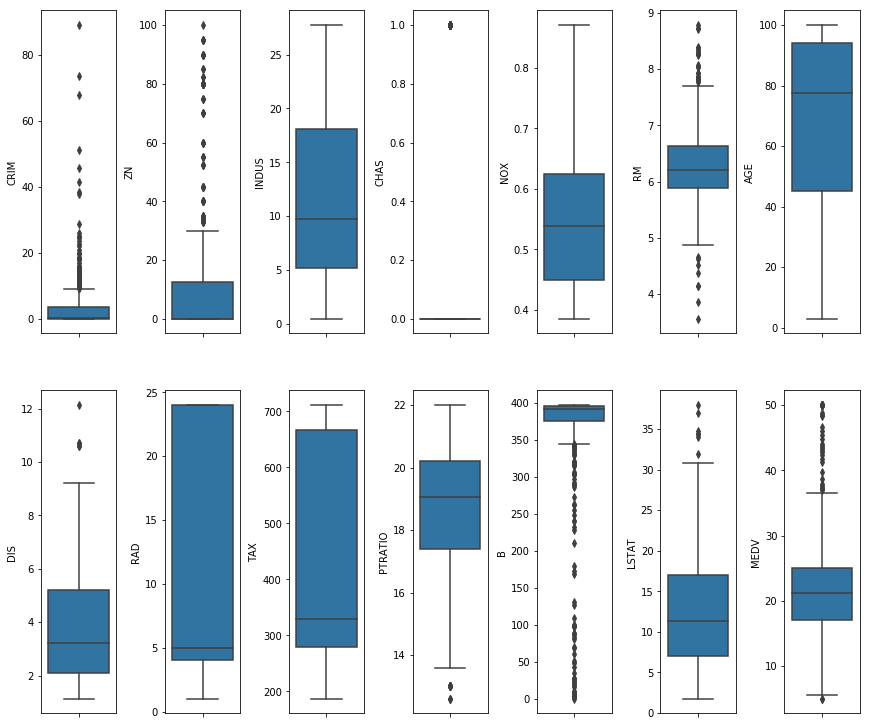

In [157]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(12, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

Можно заметить, что такие значения как CRIM, ZN, RM, B имеют выбросы. 

Посмотрим процент выбросов в данных

In [158]:
    for k, v in data.items():
    # считаем точки в квантиле 25% от медианы
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        # выбросы находятся за этими точками
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Выбросы колонки %s = %.2f%%" % (k, perc))
    

Выбросы колонки CRIM = 13.04%
Выбросы колонки ZN = 13.44%
Выбросы колонки INDUS = 0.00%
Выбросы колонки CHAS = 100.00%
Выбросы колонки NOX = 0.00%
Выбросы колонки RM = 5.93%
Выбросы колонки AGE = 0.00%
Выбросы колонки DIS = 0.99%
Выбросы колонки RAD = 0.00%
Выбросы колонки TAX = 0.00%
Выбросы колонки PTRATIO = 2.96%
Выбросы колонки B = 15.22%
Выбросы колонки LSTAT = 1.38%
Выбросы колонки MEDV = 7.91%


Так как максимальное значение переменной MEDV = 50, удалим данные, не влияющие на предсказание цен выше 50

In [159]:
print(np.shape(data))
data = data[~(data['MEDV'] >= 50.0)]
print(np.shape(data))

(506, 14)
(490, 14)


Посмотрим плотности распределения значений

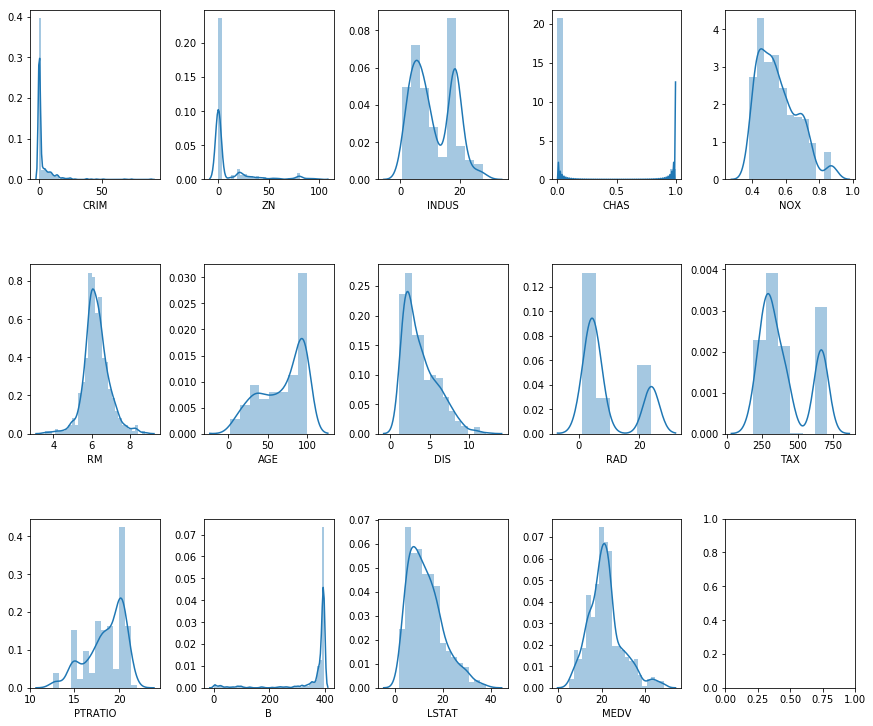

In [160]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(12, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

Такие переменные, как CRIM, ZN, B имеют перекошенное распределение. MEDV похоже на нормальное распределение. 
Другие переменные имеют либо нормальное либо биноминальное распределение, кроме CHAS (дискретная переменная).

Построим график плотности распределения колонки 'MEDV'

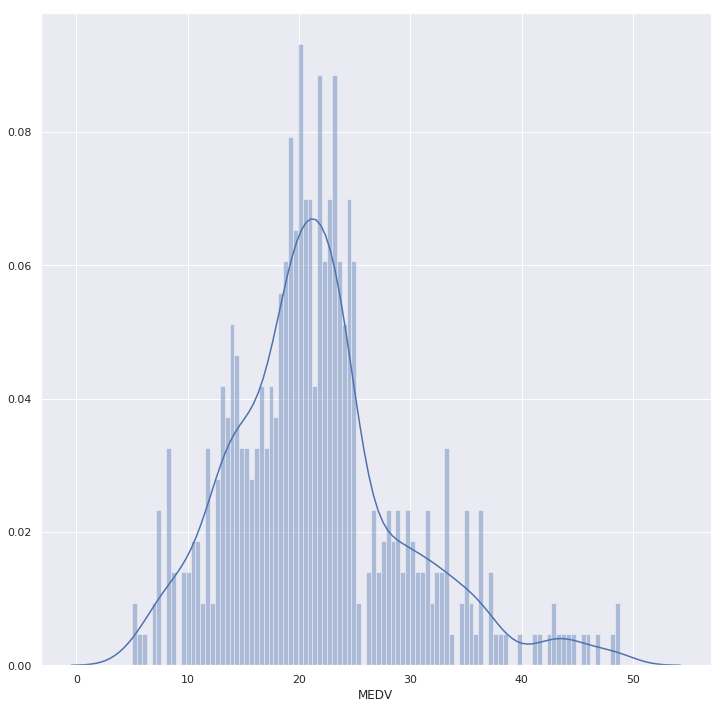

In [161]:
sns.set(rc={'figure.figsize':(12,12)})
sns.distplot(data['MEDV'], bins=100)
plt.show()

Можно заметить, что данные представляют собой нормальное распределение с некоторыми выбросами 

Построим матрицу корелляций

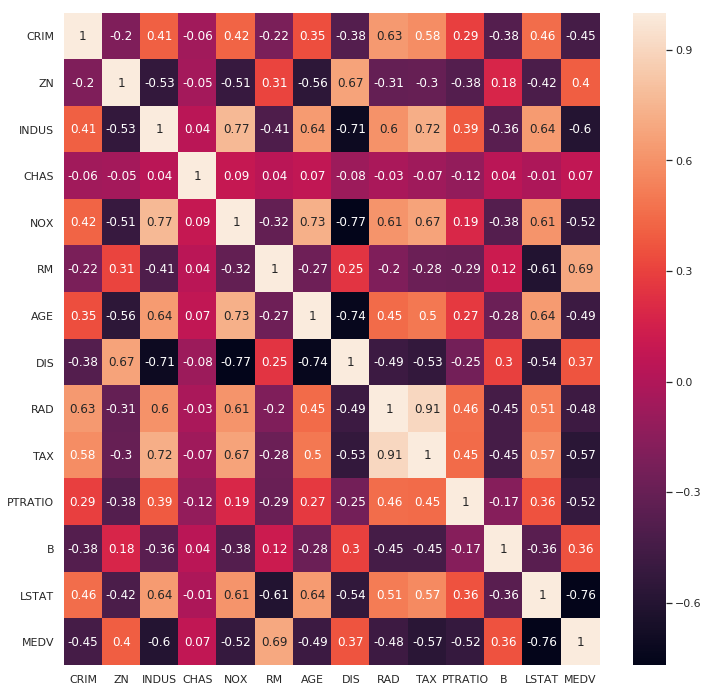

In [162]:
correlation_matrix = data.corr(method ='pearson').round(2)
# annot = True чтобы печатать значение внутри ячейки матрицы
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

In [163]:
print(sorted(correlation_matrix['MEDV']))

[-0.76, -0.6, -0.57, -0.52, -0.52, -0.49, -0.48, -0.45, 0.07, 0.36, 0.37, 0.4, 0.69, 1.0]


Наша задача - предсказать значение MEDV - средняя цена дома. Чтобы понять, какие переменные влияют на цену дома, посмотрим на корелляцию с данным значением. По сути, нам из таблицы нужны только те переменные, которые кореллируют (положительно или отрицательно) с искомым значением (MEDV). Можно увидеть, что RM имеет положительно высокую корелляцию с MEDV 0.7, вторая величина по корелляции - LTSAT (-0.74). 


*   Надо также проверять переменные на мультиколлинеарность: не стоит выбирать в качестве данных значения с высокой корелляцией. Например, следующими по величине абсолютной корелляции идут значения PTRATIO, INDUS, TAX. Мы можем их всех выбрать в качестве значимых данных, но TAX и INDUS между собой имеют корелляцию 72%, поэтому имеет смысл выбрать одну из них.  


Построим корелляцию  LSTAT, INDUS, RM, TAX, NOX, PTRAIO с MEDV, так как их абсолютное значение корелляции с MEDV более 50%

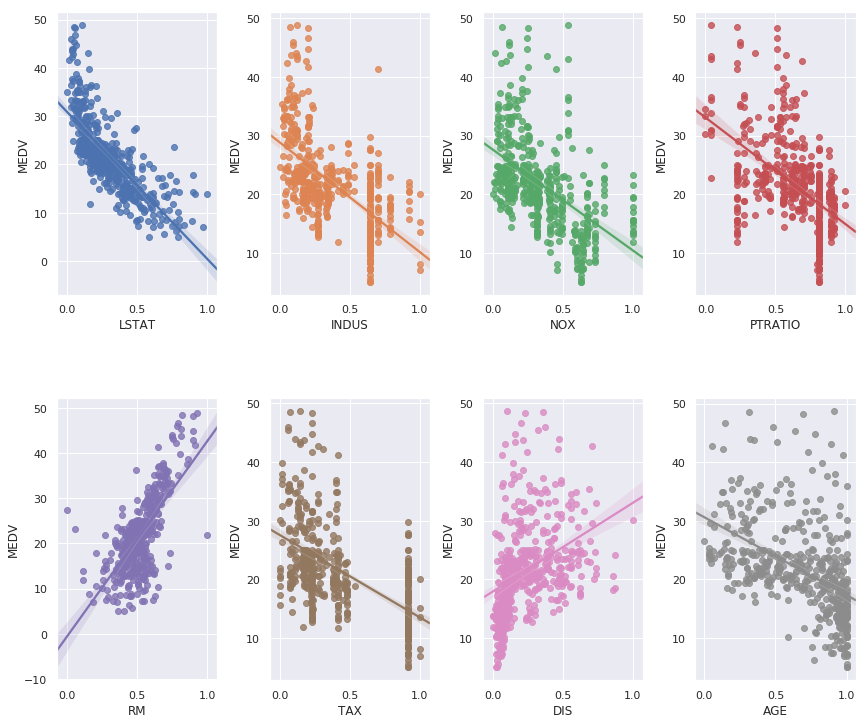

In [165]:
from sklearn import preprocessing
# нормализуем значения перед отрисовкой MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
y = data['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Наблюдения:

*   Линейная зависимость от переменной RM. Есть выбросы
*   Цена уменьшается, если увеличивается значение LSTAT. 
*   Цена увеличивается, если увеличивается RAD, особенно хорошо заметно в среднем значении, но не линейная зависимость, есть выбросы
*   Цена увеличивается, если увеличивается TAX, нелинейная зависимость, есть выбросы



Подводя итоги, мы можем выбрать для предсказания переменной MEDV такие значения, как 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE'. 

# Линейная регрессия от одной переменных:

In [0]:
from sklearn.linear_model import LinearRegression
lstat = x['LSTAT']
medv = data['MEDV']
model = LinearRegression()

In [169]:

X_train,X_test,y_train,y_test = train_test_split(lstat,
                                                 medv,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)
result = model.fit(np.array(X_train).reshape(-1,1), y_train)

print('intercept:', model.intercept_)

print('slope:', model.coef_)

intercept: 31.74766255576754
slope: [-40.03581189]


Посмотрим точность предсказаний:

In [174]:
model.score(np.array(X_test).reshape(-1,1), y_test)

0.6277470829058266

62% на тестовых данных - неплохо.

Посмотрим на линейную регрессию от одной переменной:

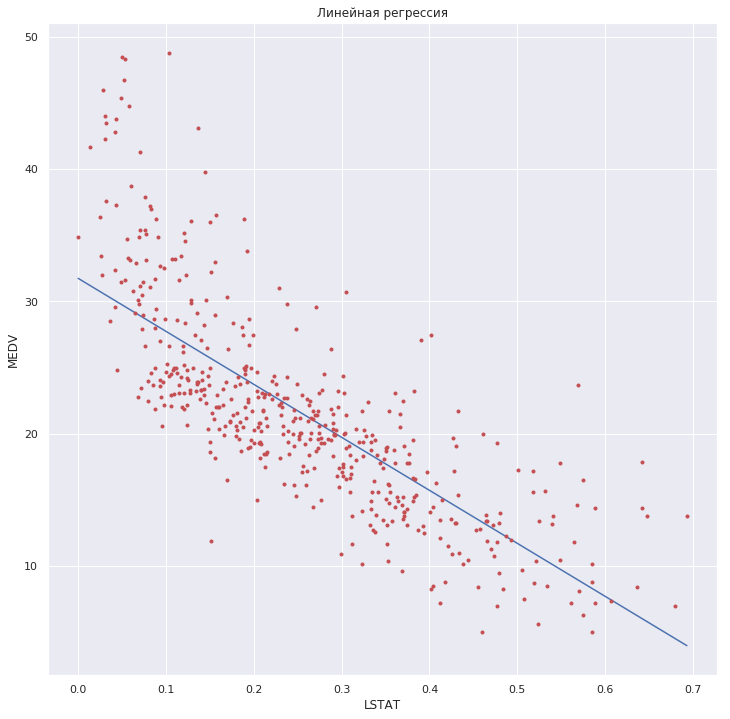

In [175]:
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.title('Линейная регрессия')
x = np.linspace(min(lstat), max(lstat), 100)
y = model.coef_*x + model.intercept_
plt.plot(x,y)
plt.plot(lstat, medv, 'r.')
plt.show()

# Линейная регрессия от нескольких переменных:

'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE'

In [177]:
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = data.loc[:,column_sels]
lstat = x['LSTAT']
indus = x['INDUS']
nox = x['NOX']
ptratio = x['PTRATIO']
rm = x['RM']
tax = x['TAX']
dis = x['DIS']
age = x['AGE']

y = data['MEDV']
x = np.vstack([np.array(lstat), np.array(indus), np.array(nox), 
               np.array(ptratio), np.array(rm), np.array(tax), 
              np.array(dis), np.array(age)]).T
print('x - это многомерная матрица,: ')
print(x[:3])
X_train,X_test,y_train,y_test = train_test_split(x,
                                                 y,
                                                 test_size = 0.3,#%70 train, 30% test
                                                 random_state = 3)

model = LinearRegression().fit(X_train, y_train)

x - это многомерная матрица,: 
[[  4.98     2.31     0.538   15.3      6.575  296.       4.09    65.2   ]
 [  9.14     7.07     0.469   17.8      6.421  242.       4.9671  78.9   ]
 [  4.03     7.07     0.469   17.8      7.185  242.       4.9671  61.1   ]]


In [178]:
print('intercept:', model.intercept_)

print('slope:', model.coef_)

intercept: 30.50437501744876
slope: [-3.46494653e-01 -1.07248752e-01 -8.19471219e+00 -7.68080047e-01
  3.79275025e+00 -6.25763985e-03 -9.35123153e-01 -3.07351432e-02]


In [179]:
model.score(X_test, y_test)

0.7494809002543231

74% - улчшение точности засчет добавления дополнительного атрибута к модели.